# Parte 1 – Propensão de inadimplência (2,5)

 Implementar em contêiner o modelo propensão de inadimplência desenvolvido na disciplina de Estatística utilizando a linguagem R ou Python.

 1. Treinar um modelo de propensão à inadimplência em R ou em Python, como visto nas aulas de estatística. (0,50)

  Nota: A API só precisa retornar a propensão à inadimplência. A criação de um modelo "fake" que retorna aleatoriamente 0 ou 1 apenas desabona esse 0,50 ponto.

2. Servir o modelo por uma API como as vistas em aula. (0,50)
  
  Nas aulas utilizamos Python + Flask, será necessário utilizar outra tecnologia, por exemplo: R + Plumber

3. Encapsular o modelo em um contêiner (1,50).– O Contêiner deve apenas receber os parâmetros de entrada e retornar a propensão da inadimplência

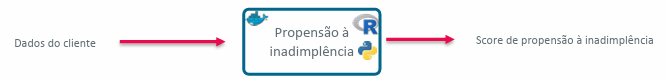

Nota: A API só precisa retornar os dados descritos no requisito 4. A criação de um modelo "fake" que retorna aleatoriamente a saída desejada desabona apenas o 0,75 ponto dos requisitos 1, 2 e 3.

## 1- Treinar um modelo de propensão à inadimplência em R ou em Python

Obs.: A implementação desse notebook foi feita em Python. Deve-se trocar o Runtime Type antes de iniciar as execuções

### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.colab import auth

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from joblib import dump

import matplotlib.pyplot as plt
import seaborn as sns

### Conexão com o Big Query

In [2]:
auth.authenticate_user()

In [3]:
# Aqui devo fazer a conexão em meu próprio projeto (utilizei o rm347975)
project_id = input("Por favor, informe o project_id: ")

Por favor, informe o project_id: rm347975


In [4]:
clientbq = bigquery.Client(project=project_id)

query_sql = f"""
  SELECT *
  FROM `emf-teacher.trabalho_loans.loan_default`
"""

query_job = clientbq.query(query_sql)  # Make an API request.
loans_data = query_job.to_dataframe()

In [5]:
loans_data.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.0,148670.0,148670.0,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.0,133572.000000,148670.0,124549.000000
mean,99224.5,2019.0,331117.743997,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,183909.310127,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.0,2019.0,16500.0,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.0,0.967478,0.0,5.000000
25%,62057.25,2019.0,196500.0,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.0,60.474860,0.0,31.000000
50%,99224.5,2019.0,296500.0,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.0,75.135870,0.0,39.000000
75%,136391.75,2019.0,436500.0,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.0,86.184211,0.0,45.000000
max,173559.0,2019.0,3576500.0,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.0,7831.250000,1.0,61.000000


In [6]:
loans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  Int64  
 1   year                       148670 non-null  Int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  Int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

### Preparação dos dados

In [7]:
# Verificar quais colunas possuem valores nulos
print(loans_data.columns[loans_data.isnull().any()])

Index(['loan_limit', 'approv_in_adv', 'loan_purpose', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'property_value', 'income', 'age', 'LTV', 'dtir1'],
      dtype='object')


In [8]:
# Remover linhas onde as colunas categóricas são nulas
loans_data = loans_data.dropna(subset=['loan_limit'])
loans_data = loans_data.dropna(subset=['approv_in_adv'])
loans_data = loans_data.dropna(subset=['loan_purpose'])
loans_data = loans_data.dropna(subset=['Neg_ammortization'])
loans_data = loans_data.dropna(subset=['age'])

In [9]:
# Substituir os valores nulos pela mediana
loans_data.loc[:, 'rate_of_interest'] = loans_data['rate_of_interest'].fillna(loans_data['rate_of_interest'].median())
loans_data.loc[:, 'Interest_rate_spread'] = loans_data['Interest_rate_spread'].fillna(loans_data['Interest_rate_spread'].median())
loans_data.loc[:, 'Upfront_charges'] = loans_data['Upfront_charges'].fillna(loans_data['Upfront_charges'].median())
loans_data.loc[:, 'term'] = loans_data['term'].fillna(loans_data['term'].median())
loans_data.loc[:, 'property_value'] = loans_data['property_value'].fillna(loans_data['property_value'].median())
loans_data.loc[:, 'income'] = loans_data['income'].fillna(loans_data['income'].median())
loans_data.loc[:, 'LTV'] = loans_data['LTV'].fillna(loans_data['LTV'].median())
loans_data.loc[:, 'dtir1'] = loans_data['dtir1'].fillna(loans_data['dtir1'].median())

In [10]:
# Conferindo se sobraram colunas com valores nulos
print(loans_data.columns[loans_data.isnull().any()])

Index([], dtype='object')


In [11]:
nomes_colunas  =   ["loan_limit",               "approv_in_adv",        "loan_type",
                    "loan_purpose",             "Credit_Worthiness",     "Interest_rate_spread",
                    "Neg_ammortization",        "interest_only",         "lump_sum_payment",
                    "occupancy_type",           "total_units",           "credit_type",
                    "co_applicant_credit_type", "age",                   "submission_of_application",
                    "Region",                   "Status"]
loans_data_classif = loans_data.loc[:, nomes_colunas]

loans_data_classif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143983 entries, 0 to 148669
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 143983 non-null  object 
 1   approv_in_adv              143983 non-null  object 
 2   loan_type                  143983 non-null  object 
 3   loan_purpose               143983 non-null  object 
 4   Credit_Worthiness          143983 non-null  object 
 5   Interest_rate_spread       143983 non-null  float64
 6   Neg_ammortization          143983 non-null  object 
 7   interest_only              143983 non-null  object 
 8   lump_sum_payment           143983 non-null  object 
 9   occupancy_type             143983 non-null  object 
 10  total_units                143983 non-null  object 
 11  credit_type                143983 non-null  object 
 12  co_applicant_credit_type   143983 non-null  object 
 13  age                        14

In [12]:
# Usando o método one-hot-encode para tratar as variáveis categóricas
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['loan_limit'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['approv_in_adv'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['loan_type'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['loan_purpose'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['Credit_Worthiness'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['Neg_ammortization'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['interest_only'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['lump_sum_payment'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['occupancy_type'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['credit_type'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['total_units'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['co_applicant_credit_type'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['age'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['submission_of_application'])
loans_data_classif = pd.get_dummies(loans_data_classif, columns=['Region'])

In [13]:
# Forçando a ordem das colunas definida
ordem_colunas = ['Interest_rate_spread','loan_limit_cf','approv_in_adv_nopre','loan_type_type3','loan_purpose_p4','Credit_Worthiness_l1','Neg_ammortization_not_neg','interest_only_not_int','lump_sum_payment_lpsm','occupancy_type_ir','credit_type_CRIF','total_units_1U','co_applicant_credit_type_EXP','age_25-34','submission_of_application_to_inst','Region_North','loan_limit_ncf','approv_in_adv_pre','loan_type_type1','loan_type_type2','loan_purpose_p1','loan_purpose_p2','loan_purpose_p3','Credit_Worthiness_l2','Neg_ammortization_neg_amm','interest_only_int_only','lump_sum_payment_not_lpsm','occupancy_type_pr','occupancy_type_sr','credit_type_CIB','credit_type_EQUI','credit_type_EXP','total_units_2U','total_units_3U','total_units_4U','co_applicant_credit_type_CIB','age_35-44','age_45-54','age_55-64','age_65-74','age_<25','age_>74','submission_of_application_not_inst','Region_North-East','Region_central','Region_south','Status']
loans_data_classif = loans_data_classif.reindex(columns=ordem_colunas)

In [14]:
loans_data_classif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143983 entries, 0 to 148669
Data columns (total 47 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Interest_rate_spread                143983 non-null  float64
 1   loan_limit_cf                       143983 non-null  uint8  
 2   approv_in_adv_nopre                 143983 non-null  uint8  
 3   loan_type_type3                     143983 non-null  uint8  
 4   loan_purpose_p4                     143983 non-null  uint8  
 5   Credit_Worthiness_l1                143983 non-null  uint8  
 6   Neg_ammortization_not_neg           143983 non-null  uint8  
 7   interest_only_not_int               143983 non-null  uint8  
 8   lump_sum_payment_lpsm               143983 non-null  uint8  
 9   occupancy_type_ir                   143983 non-null  uint8  
 10  credit_type_CRIF                    143983 non-null  uint8  
 11  total_units_1U            

### Treino do modelo - Regressão Logística

In [15]:
# Separar os dados em features (X) e target (y)
X = loans_data_classif.drop('Status', axis=1)
y = loans_data_classif['Status']

In [16]:
# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Inicializar e treinar o modelo de regressão logística
model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [19]:
# Salvar o modelo em um arquivo
dump(model, 'logReg_model.pkl')

['logReg_model.pkl']

In [20]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

In [21]:
# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo de regressão logística: {:.2f}%".format(accuracy * 100))

Acurácia do modelo de regressão logística: 86.90%


## 4- Criação da API

### Criação da API Flask

#### Tentativa pelo Google Colab

Conforme pudemos verificar nos testes da API Plumber (R), o Google Colab possui particularidades, que dificultam a criação da API por aqui.
Desta forma, utilizamos o Jupyter Notebook para implementarmos a próxima parte.

#### Tentativa pelo Jupyter Notebook

Foi implementado o arquivo **api_parte1.py** no Jupyter Notebook.
É importante salvar o arquivo do modelo obtido durante o treino do modelo em sua pasta, respeitando essa organização:

- root->
  - api_parte1.py
  - config->
    - logReg_model.pkl

Código Fonte:


```
from flask import Flask, request, jsonify
import numpy as np
import pandas as pd
import joblib

# Funções de apoio
# -------------------------------------------------------------------------------------------------------
def init():
    global modelo_rlog

    # Carregar o modelo de Regressão Logística
    modelo_rlog = joblib.load('./config/logReg_model.pkl')

def one_hot_encode_columns(df, columns):
    for column in columns:
        df = pd.get_dummies(df, columns=[column])
    return df  

# Definições da API
# -------------------------------------------------------------------------------------------------------
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    # Obter os dados do cliente do request
    data = request.get_json()
    features = data['features']
    loans_data_classif = pd.DataFrame(features)

    # Tratando as colunas categóricas
    columns_to_encode = ['loan_limit', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness',
                         'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'occupancy_type',
                         'credit_type', 'total_units', 'co_applicant_credit_type', 'age',
                         'submission_of_application', 'Region']    
    loans_data_classif = one_hot_encode_columns(loans_data_classif, columns_to_encode)


    # Garantindo que todas as colunas necessárias estão no dataset
    columns_to_check = ['loan_limit_cf', 'loan_limit_ncf',
                        'approv_in_adv_nopre', 'approv_in_adv_pre',
                        'loan_type_type1', 'loan_type_type2', 'loan_type_type3',
                        'loan_purpose_p1', 'loan_purpose_p2', 'loan_purpose_p3', 'loan_purpose_p4',
                        'Credit_Worthiness_l1', 'Credit_Worthiness_l2',
                        'Neg_ammortization_neg_amm', 'Neg_ammortization_not_neg',
                        'interest_only_int_only', 'interest_only_not_int',
                        'lump_sum_payment_lpsm', 'lump_sum_payment_not_lpsm',
                        'occupancy_type_ir', 'occupancy_type_pr', 'occupancy_type_sr',
                        'credit_type_CIB', 'credit_type_CRIF', 'credit_type_EQUI', 'credit_type_EXP',
                        'total_units_1U', 'total_units_2U', 'total_units_3U', 'total_units_4U',
                        'co_applicant_credit_type_CIB', 'co_applicant_credit_type_EXP',
                        'age_25-34', 'age_35-44', 'age_45-54', 'age_55-64', 'age_65-74', 'age_<25', 'age_>74',
                        'submission_of_application_not_inst', 'submission_of_application_to_inst',
                        'Region_North', 'Region_North-East', 'Region_central', 'Region_south'
                        ]
    
    # Verificar se as colunas estão presentes, atribuindo False para as colunas ausentes
    missing_columns = [col for col in columns_to_check if col not in loans_data_classif.columns]
    for col in missing_columns:
        loans_data_classif[col] = False

    # Forçando a ordem das colunas definida
    ordem_colunas = ['Interest_rate_spread','loan_limit_cf','approv_in_adv_nopre','loan_type_type3','loan_purpose_p4','Credit_Worthiness_l1','Neg_ammortization_not_neg','interest_only_not_int','lump_sum_payment_lpsm','occupancy_type_ir','credit_type_CRIF','total_units_1U','co_applicant_credit_type_EXP','age_25-34','submission_of_application_to_inst','Region_North','loan_limit_ncf','approv_in_adv_pre','loan_type_type1','loan_type_type2','loan_purpose_p1','loan_purpose_p2','loan_purpose_p3','Credit_Worthiness_l2','Neg_ammortization_neg_amm','interest_only_int_only','lump_sum_payment_not_lpsm','occupancy_type_pr','occupancy_type_sr','credit_type_CIB','credit_type_EQUI','credit_type_EXP','total_units_2U','total_units_3U','total_units_4U','co_applicant_credit_type_CIB','age_35-44','age_45-54','age_55-64','age_65-74','age_<25','age_>74','submission_of_application_not_inst','Region_North-East','Region_central','Region_south']
    loans_data_classif = loans_data_classif.reindex(columns=ordem_colunas)
    
    # Executar a predição da propensão de inadimplência através do modelo de Regressão Logística
    # scaled_features = modelo_rlog.fit(loans_data_classif)
    propensao = modelo_rlog.predict(loans_data_classif)[0]
    
    # Retornar os resultados como JSON
    return jsonify({
        'propension': int(propensao)
    })
    
    # return loans_data_classif.to_json(orient="records")

# Definir a rota raiz
@app.route("/", methods=['GET', 'POST'])
def call_home(request = request):
    print(request.values)
    return "Parte_1: Server is ready to be used!!!\n"

if __name__ == '__main__':
    init()
    app.run(port=8080, host = '0.0.0.0')
```



Para executar a API localmente, devemos executar no Terminal ou CMD o arquivo **api_parte1.py**:

```
python api_parte1.py
```



Abaixo, evidências do teste.

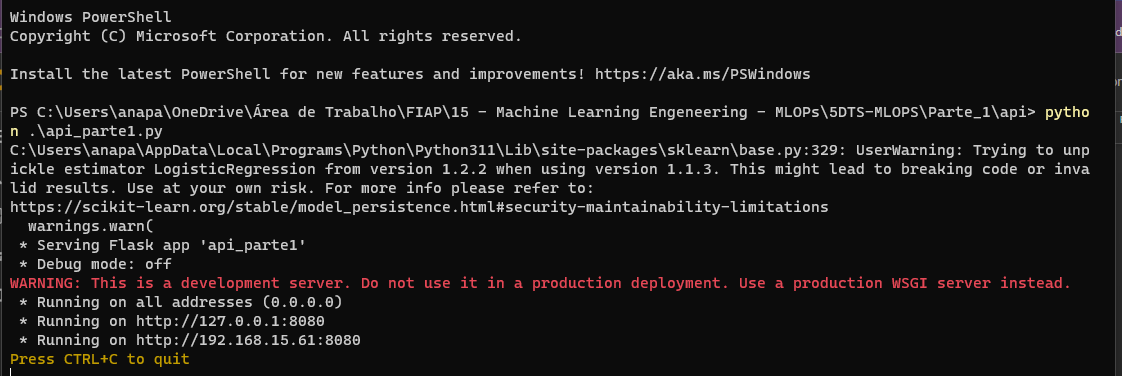

URL da API: http://127.0.0.1:8080/predict

Exemplo de payload:
```
{
    "features": [
        {
            "loan_limit": "cf",
            "approv_in_adv": "nopre",
            "loan_type": "type3",
            "loan_purpose": "p4",
            "Credit_Worthiness": "l1",
            "Interest_rate_spread": 10.39,
            "Neg_ammortization": "not_neg",
            "interest_only": "not_int",
            "lump_sum_payment": "lpsm",
            "occupancy_type": "ir",
            "total_units": "4U",
            "credit_type": "CRIF",
            "co_applicant_credit_type": "EXP",
            "age": "25-34",
            "submission_of_application": "to_inst",
            "Region": "North"
        }
    ]
}
```

Evidência da execução no Postman:

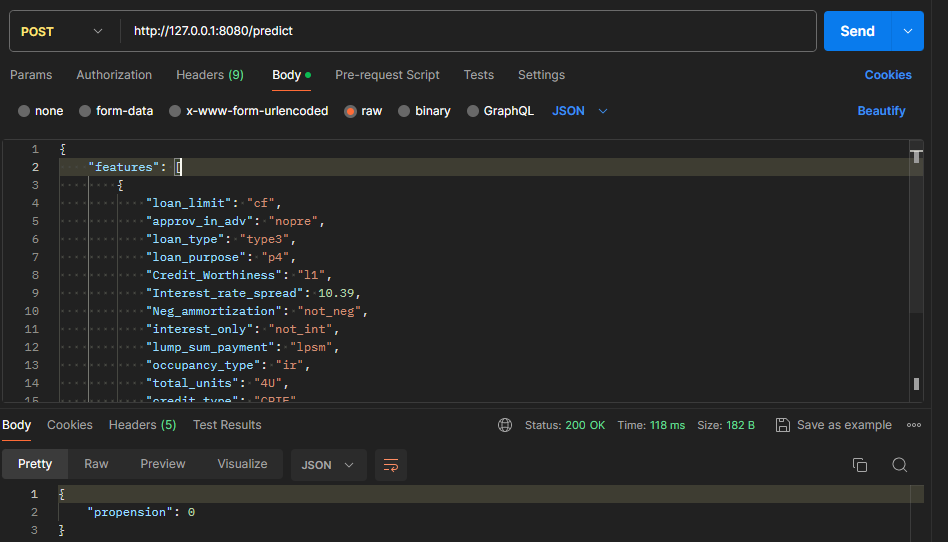

## 5- Encapsular o modelo em um contêiner

### Preparação do arquivo requirements.txt

Nesse momento, é importante salvar em um arquivo as blibliotecas necessárias para que a API execute corretamente.
Para isso, acessar o Terminal ou CMD, salvando o resultado em um arquivo **requirements.txt**.
```
pip freeze
```



Obs.: Esse arquivo deve ser salvo na mesma pasta onde está o arquivo **api_parte1.py**.

### Preparação do arquivo Dockerfile

Salvar um arquivo Dockerfile (sem extensão) o código a seguir:
```
FROM python:3.10
LABEL maintainer="Ana Paula Lavieri"
LABEL version="1.0"

RUN apt-get update
RUN apt-get install nano

RUN mkdir -p /myServer

COPY . /myServer

WORKDIR /myServer

RUN pip install --upgrade pip
RUN pip install -r /myServer/requirements.txt

EXPOSE 8080

CMD [ "python", "api_parte1.py" ]
```



Nesse arquivo estamos preparando a instalação dos componentes necessários para colocar a API em um container.

Basicamente estamos:
- Instalando alguns componentes necessários do Docker
- Copiando os arquivos de nossa solução para a pasta de trabalho
- Instalando as bibliotecas definidas no arquivo requirements.txt
- Expondo o container na porta 8080
- Executando a API api_parte1.py quando o container for chamado

Obs.: Explicamos melhor, de forma global, a preparação dos containers em uma máquina virtual, no arquivo **MLOPS_Trabalho_Integrado.ipynb**.

Abaixo, organização dos arquivos em pastas:

- root->
  - Parte_1->
    - api->
      - config->
        - logReg_model.pkl
      - api_parte1.py
      - requirements.txt
    - dockerbuilds->
      - Dockerfile


### Evidência do teste de execução do modelo em Container

Observações:
- A máquina virtual já está preparada
- As imagens do Docker já estão OK
- Os a solução já foi instalada na imagem
- O container já está montado

Para acessar a máquina virtual, utilizamos o comando, informando a senha quando foi solicitada:
```
ssh vm-grupo-mlops@52.226.67.177
```



Conferindo a montagem dos containers (o deste modelo é o parte1_api)

```
sudo docker ps
```

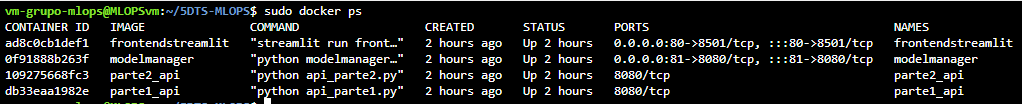

Executando um GET simples, apenas para conferir se o serviço está OK
```
curl http://172.19.0.2:8080/
```



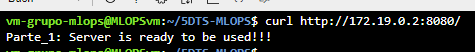

Executando o modelo propriamente dito
```
curl -X POST -H "Content-Type: application/json" -d '{"model":"parte1_api","features": [{"loan_limit": "cf","approv_in_adv": "nopre","loan_type": "type3","loan_purpose": "p4","Credit_Worthiness": "l1","Interest_rate_spread": 0.39,"Neg_ammortization": "not_neg","interest_only": "not_int","lump_sum_payment": "lpsm","occupancy_type": "ir","total_units": "1U","credit_type": "CRIF","co_applicant_credit_type": "EXP","age": "25-34","submission_of_application": "to_inst","Region": "North"}]}' http://172.19.0.2:8080/predict
```

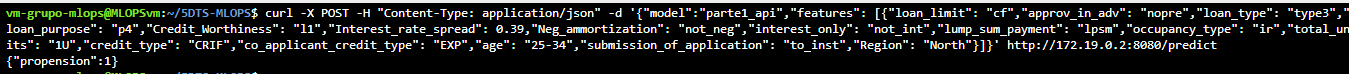